In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch

from bmadx import M_ELECTRON
from bmadx.bmad_torch.track_torch import Beam
from bmadx.coordinates import openPMD_to_bmadx
from bmadx.plot import plot_projections

from initial_beam import create_initial_beam
from training import generate_training_images, train_model

/home/jp/mambaforge/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create Initial Beam

In [2]:
# create openPMD-beamphysics particle group
par = create_initial_beam('data/gaussian.yaml')

(6, 100000)


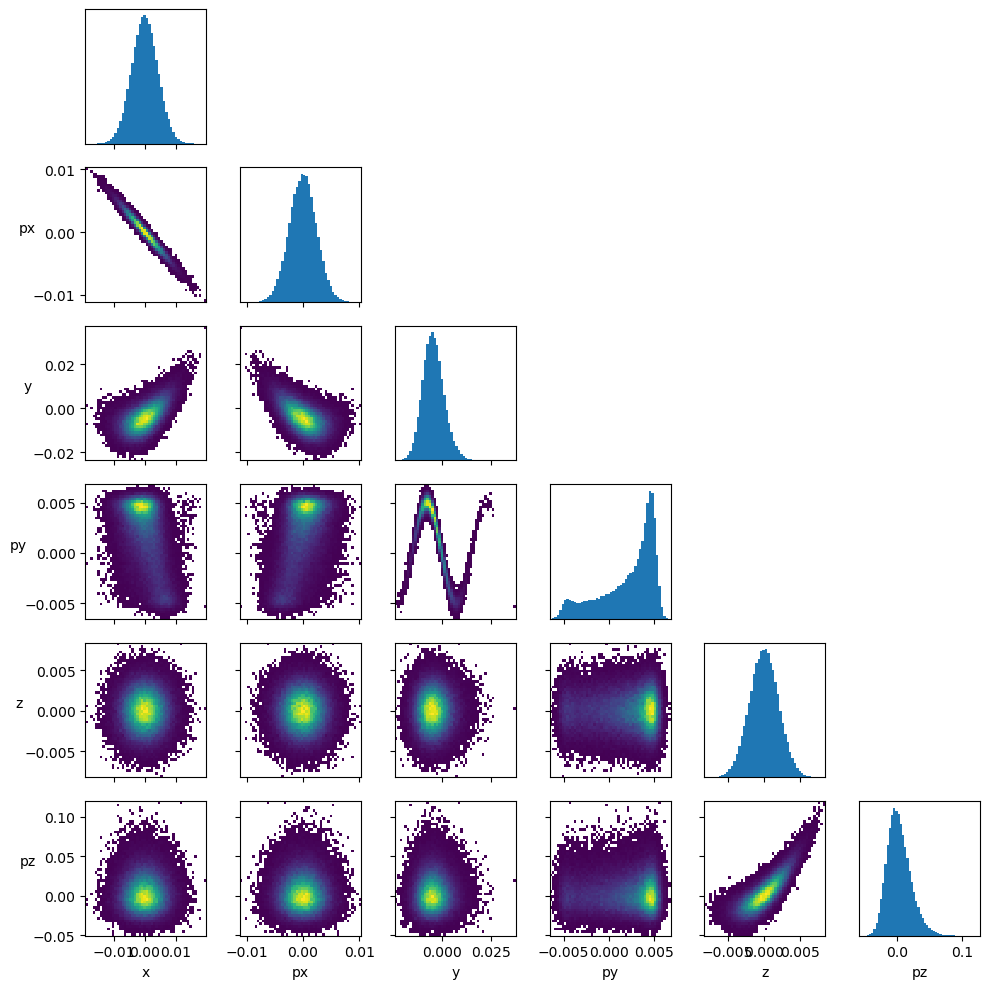

In [3]:
# transform to bmad phase space coordinates
p0c = 10.0e6 # reference momentum in eV
coords = np.array(openPMD_to_bmadx(par, p0c))
print(coords.shape)

# create bmad-x pytorch beam:
beam_in = Beam(
    torch.tensor(coords),
    s=torch.tensor(0.0),
    p0c=torch.tensor(10.0e6),
    mc2=torch.tensor(M_ELECTRON)
)

# plot projections
plot_projections(np.array(coords),
                 labels=['x', 'px', 'y', 'py', 'z', 'pz'],
                 bins=50,
                 background=False)

## Track through reconstruction lattice

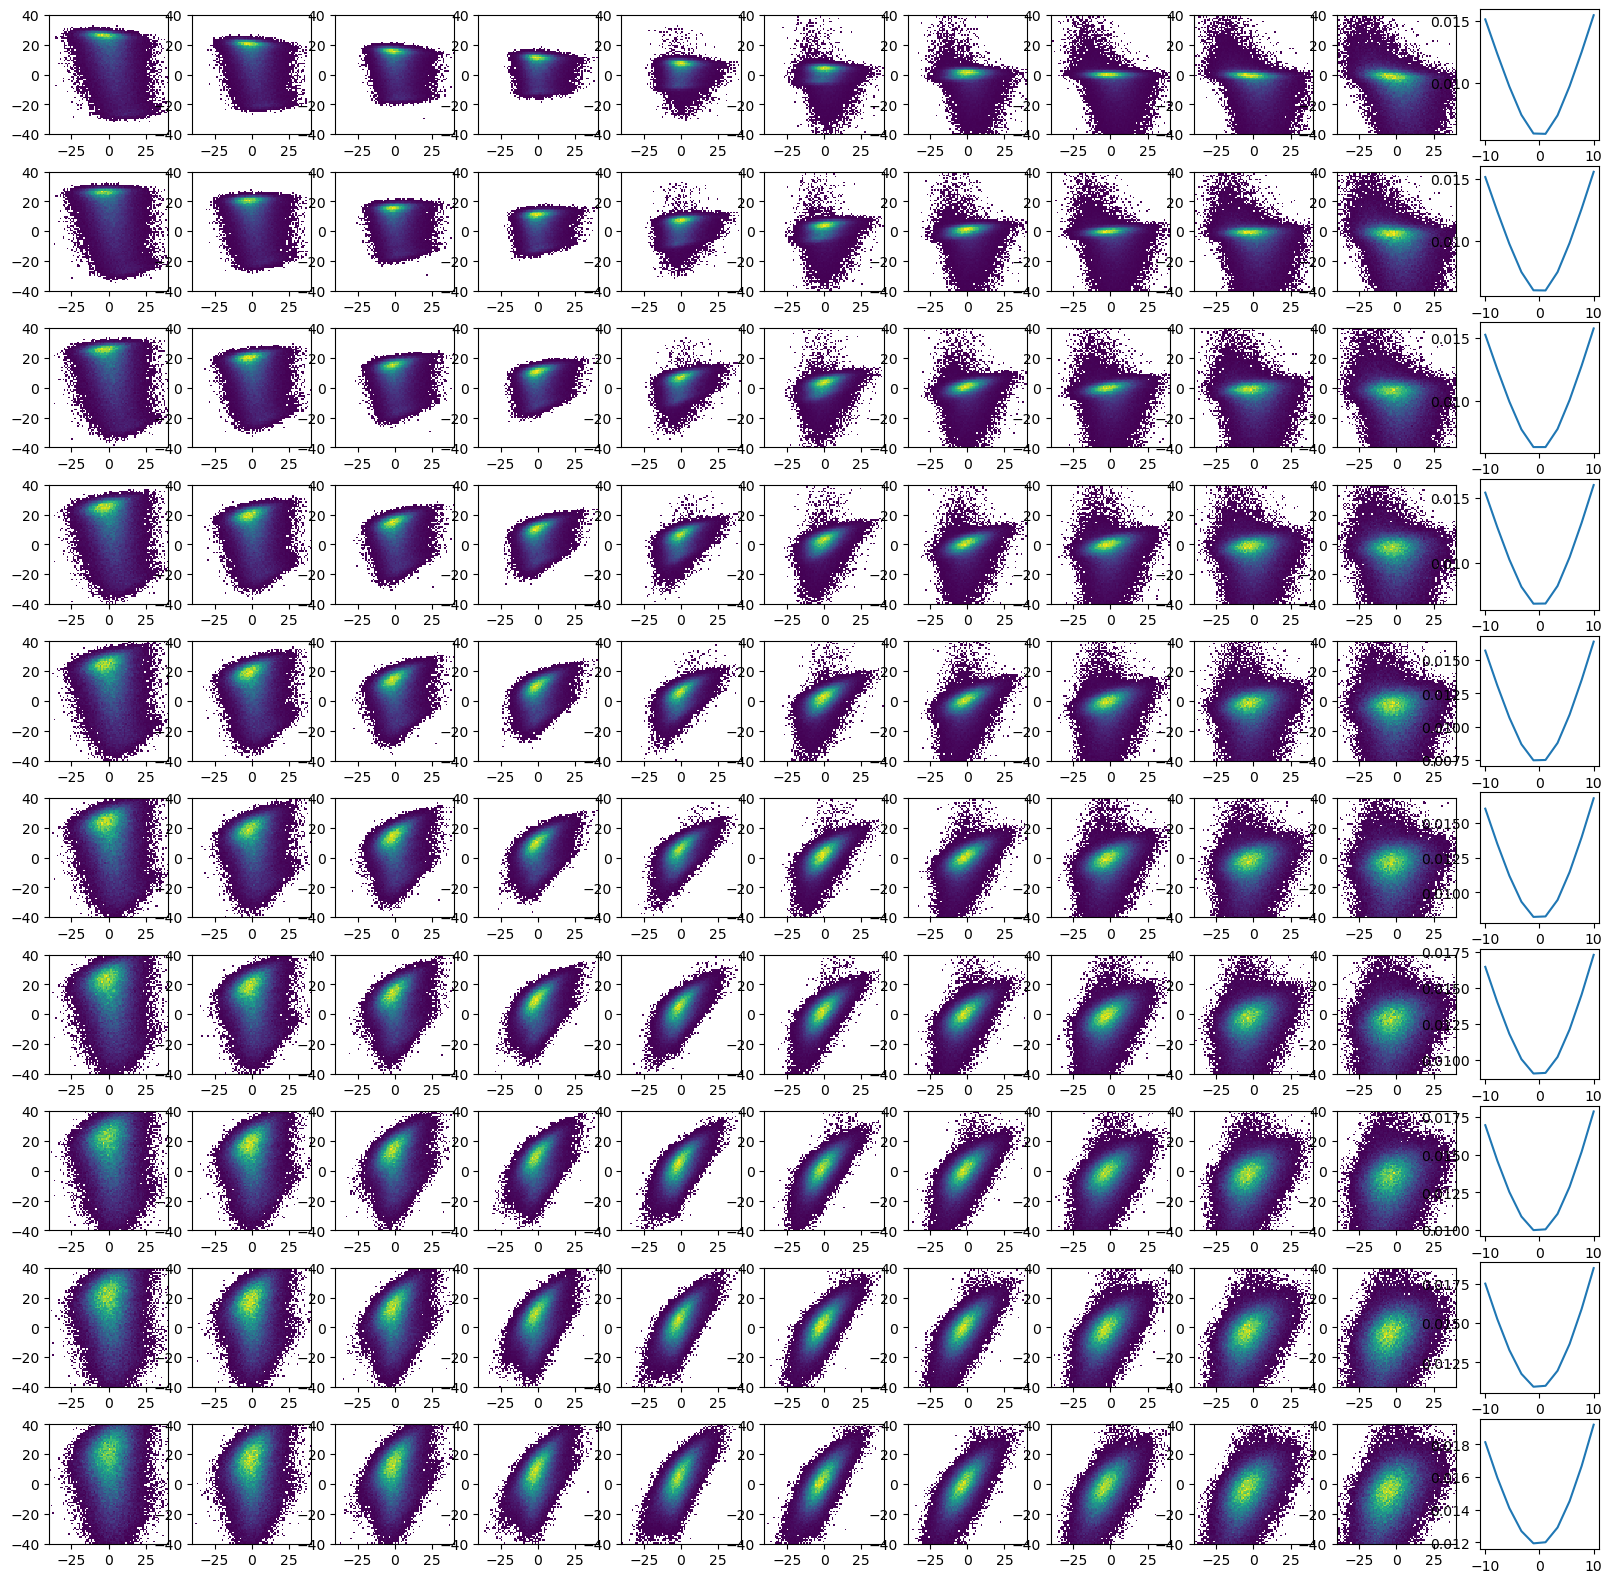

In [4]:
from beamline import create_6d_diagnostic_beamline

# Create lattice
lattice = create_6d_diagnostic_beamline()

# Scan over K1 values and plot final beam profile
k1s = np.linspace(-10,10,10)
sigma_ys = np.zeros_like(k1s)
voltages = np.linspace(0,1e6,10)

mycmap = plt.get_cmap('viridis') # viridis plasma inferno magma and _r versions
mycmap.set_under(color='white') # map 0 to this color
myvmin = 1 # something tiny

fig, ax = plt.subplots(10,11, figsize=(20,20))

for i, voltage in enumerate(voltages):
    lattice.elements[2].VOLTAGE.data = torch.tensor(voltage)
    for j, k1 in enumerate(k1s):
        lattice.elements[0].K1.data = torch.tensor(k1)
        beam_out = lattice(beam_in)
        sigma_ys[j] = beam_out.y.std().detach().numpy()
        # Bin particles
        ax[i, j].hist2d(x=1000*beam_out.x.numpy(), y=1000*beam_out.y.numpy(),  bins=[80,80], range=[[-40,40],[-40,40]] ,cmap=mycmap, vmin=myvmin)
        ax[i, j].set_aspect('equal')

    ax[i, j+1].plot(k1s, sigma_ys)